In [1]:
radar = pyart.io.read('KDDC20160524_181120_V06.gz')
radar = pyart.io.read('KDDC20160525_001527_V06.gz')
radar = pyart.io.read('KDDC20160524_181120_V06.gz')


field = 'velocity'
field = 'reflectivity'

field = 'differential_phase'
field = "spectrum_width"
field = 'differential_reflectivity'
field = 'cross_correlation_ratio'

field = 'reflectivity'
field = 'velocity'

In [2]:
display = pyart.graph.RadarDisplay(radar)

In [3]:
radar.iter_azimuth?


In [4]:
LookUp = []
iter_obj = radar.iter_elevation()
for n, elev in enumerate(iter_obj):
    if elev.shape[0] == 720:
        if np.mod(n,2) == 0:
            LookUp.append((n, n+1))
    else:
        LookUp.append((n,n))
   
print LookUp

[(0, 1), (2, 3), (4, 4), (5, 5), (6, 6)]


In [5]:
for n, m in LookUp:
    begin, end = radar.get_start_end(n)
    dbz = radar.get_field(n, 'reflectivity')
    vel = radar.get_field(m, 'velocity')
    print("DBZ index:  %d   VEL index:  %d" % (n,m))
    print("REF  :  %d" % (np.sum(dbz.mask == False)))
    print("VEL  :  %d" % (np.sum(vel.mask == False)))



DBZ index:  0   VEL index:  1
REF  :  322059
VEL  :  309536
DBZ index:  2   VEL index:  3
REF  :  226210
VEL  :  217490
DBZ index:  4   VEL index:  4
REF  :  71177
VEL  :  69093
DBZ index:  5   VEL index:  5
REF  :  50419
VEL  :  49002
DBZ index:  6   VEL index:  6
REF  :  40016
VEL  :  38333


In [6]:
for n, sweep in enumerate(radar.iter_field(field)):
    begin, end = radar.get_start_end(n)
    print radar.elevation['data'][begin:end].mean()
    print("%s  :  %f  %f" % (field, sweep.data[n].max(), sweep.data[n].min()))
    print("%s  :  %d" % (field, np.sum(sweep.mask[n] == True)))
    print("%s  :  %d" % (field, np.sum(sweep.mask[n] == False)))


0.471652
velocity  :  -64.000000  -64.000000
velocity  :  1832
velocity  :  0
0.4685
velocity  :  16.500000  -64.500000
velocity  :  1341
velocity  :  491
1.48227
velocity  :  -64.000000  -64.000000
velocity  :  1832
velocity  :  0
1.48045
velocity  :  9.500000  -64.500000
velocity  :  1470
velocity  :  362
2.49125
velocity  :  10.000000  -64.500000
velocity  :  1610
velocity  :  222
3.5026
velocity  :  11.000000  -64.500000
velocity  :  1663
velocity  :  169
4.47208
velocity  :  10.500000  -64.500000
velocity  :  1710
velocity  :  122


In [7]:
radar.get_field?

In [8]:
data = radar.get_field(0, 'reflectivity')


In [9]:
data



masked_array(data =
 [[8.0 8.5 -- ..., -- -- --]
 [4.0 8.5 -- ..., -- -- --]
 [1.0 6.5 15.0 ..., -- -- --]
 ..., 
 [4.0 5.0 6.5 ..., -- -- --]
 [2.5 2.0 1.0 ..., -- -- --]
 [1.5 2.5 0.0 ..., -- -- --]],
             mask =
 [[False False  True ...,  True  True  True]
 [False False  True ...,  True  True  True]
 [False False False ...,  True  True  True]
 ..., 
 [False False False ...,  True  True  True]
 [False False False ...,  True  True  True]
 [False False False ...,  True  True  True]],
       fill_value = 1e+20)

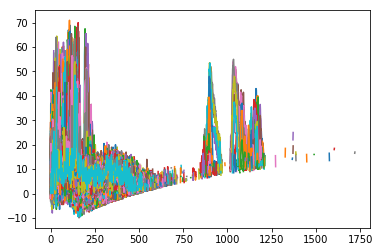

In [10]:
for na in np.arange(data.shape[0]):
    d2 = data
    plt.plot(data[na])
plt.show()

In [39]:


def texture(input, len=9):
    
    radius = len/2
    
    def rolling_window(a, window):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    
    i2     = np.where(input.mask == True, np.nan, input)
    std    = np.zeros(i2.shape)
    kernel = np.ones((len,))/np.float(len)
    c1     = scipy.ndimage.filters.convolve1d(i2,    kernel, mode='nearest', origin=-radius)
    c2     = scipy.ndimage.filters.convolve1d(i2*i2, kernel, mode='nearest', origin=-radius)
    std[len/2:-len/2+1] = ((c2 - c1*c1)**.5)[len-1:]

    
#     c1 = scipy.ndimage.filters.uniform_filter(i2, radius*2, mode='nearest', origin=-radius)
#     c2 = scipy.ndimage.filters.uniform_filter(i2*i2, radius*2, mode='nearest', origin=-radius)
    
#     std = scipy.ndimage.generic_filter(i2, np.nanstd, size=2*radius)
#     print std.shape, std
# #     print std.shape, std
# #     std = scipy.ndimage.generic_filter(i2, np.std, size=len, origin=(-len[0]/2,-len[1]/2))
#     std = np.zeros(input.shape)
#     for i in np.arange(radius, input.shape[0]-radius):
#         std[i] = np.std(i2[i-radius:i+radius])

#     print radius, input.shape[0]-radius, std.shape, std

#     std = np.nanstd(rolling_window(i2, len), 1)

    return np.ma.array(std, mask=np.isnan(std))

np.random.seed(123478)
test = np.ma.MaskedArray(np.random.normal(size=27), mask=False)
test.mask[13] = True
t_array = texture(test)
print t_array.shape, t_array
# t_array = texture(data)
# print t_array.shape

(27,) [0.0 0.0 0.0 0.0 0.7487991801848988 0.759518292222321 0.6766976659758372
 0.6694947050190269 0.6499165837433125 -- -- -- -- -- -- -- -- --
 0.7798968911934325 0.8385700142245975 0.7122656509299846
 0.7944612928542579 0.8064472405006986 0.0 0.0 0.0 0.0]


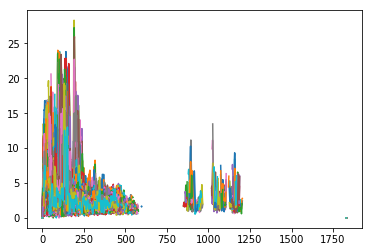

In [40]:
for na in np.arange(data.shape[0]):
    plt.plot(texture(data[na]))
plt.show()